# sprint 自然言語処理入門

### IMDBをカレントフォルダにダウンロード

In [4]:
# 解凍
!tar zxf aclImdb_v1.tar.gz
# aclImdb/train/unsupはラベル無しのため削除
!rm -rf aclImdb/train/unsup
# IMDBデータセットの説明を表示
!cat aclImdb/README

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a scor

In [53]:
from sklearn.datasets import load_files
train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target
test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target
# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


In [2]:
print("x : {}".format(x_train[0]))

x : Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.


## 4.古典的な手法
古典的ながら現在でも強力な手法であるBoWとTF-IDFを見ていきます。

## 5.BoW
単純ながら効果的な方法として BoW (Bag of Words) があります。これは、サンプルごとに単語などの 登場回数 を数えたものをベクトルとする方法です。単語をカテゴリとして捉え one-hot表現 していることになります。

In [3]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

この3文にBoWを適用させてみます。scikit-learnのCountVectorizerを利用します。
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(mini_dataset)).toarray()
# DataFrameにまとめる
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


例にあげた3文の中で登場する8種類の単語が列名になり、0,1,2番目のサンプルでそれらが何回登場しているかを示しています。2番目のサンプル「Very bad. Very, very bad.」ではbadが2回、veryが3回登場しています。列名になっている言葉はデータセットが持つ 語彙 と呼びます。


テキストはBoWにより各サンプルが語彙数の次元を持つ特徴量となり、機械学習モデルへ入力できるようになります。この時使用したテキスト全体のことを コーパス と呼びます。語彙はコーパスに含まれる言葉よって決まり、それを特徴量としてモデルの学習を行います。そのため、テストデータではじめて登場する語彙はベクトル化される際に無視されます。

## 前処理
CountVectorizerクラスでは大文字は小文字に揃えるという 前処理 が自動的に行われています。こういった前処理は自然言語処理において大切で、不要な記号などの消去（テキストクリーニング）や表記揺れの統一といったことを別途行うことが一般的です。


語形が「see」「saw」「seen」のように変化する単語に対して語幹に揃える ステミング と呼ばれる処理を行うこともあります。

## トークン
BoWは厳密には単語を数えているのではなく、 トークン（token） として定めた固まりを数えます。


何をトークンとするかはCountVectorizerでは引数token_patternで 正規表現 の記法により指定されます。デフォルトはr'(?u)\b\w\w+\b'ですが、上の例ではr'(?u)\b\w+\b'としています。


デフォルトでは空白・句読点・スラッシュなどに囲まれた2文字以上の文字を1つのトークンとして抜き出すようになっているため、「a」や「I」などがカウントされません。英語では1文字の単語は文章の特徴をあまり表さないため、除外されることもあります。しかし、上の例では1文字の単語もトークンとして抜き出すように引数を指定しています。


《正規表現》


正規表現は前処理の際にも活用しますが、ここでは詳細は扱いません。Pythonではreモジュールによって正規表現操作ができます。


re — 正規表現操作
https://docs.python.org/ja/3/library/re.html


正規表現を利用する際はリアルタイムで結果を確認できる以下のようなサービスが便利です。


Online regex tester and debugger: PHP, PCRE, Python, Golang and JavaScript
https://regex101.com/

## 形態素解析
英語などの多くの言語では空白という分かりやすい基準でトークン化が行えますが、日本語ではそれが行えません。


日本語では名詞や助詞、動詞のように異なる 品詞 で分けられる単位で 分かち書き することになります。例えば「私はプログラミングを学びます」という日本語の文は「私/は/プログラミング/を/学び/ます」という風になります。


これには MeCab や Janome のような形態素解析ツールを用います。Pythonから利用することも可能です。MeCabをウェブ上で簡単に利用できるWeb茶まめというサービスも国立国語研究所が提供しています。


自然言語では新しい言葉も日々生まれますので、それにどれだけ対応できるかも大切です。MeCab用の毎週更新される辞書として mecab-ipadic-NEologd がオープンソースで存在しています
https://github.com/neologd/mecab-ipadic-neologd/blob/master/README.ja.md

## n-gram
上のBoWの例では1つの単語（トークン）毎の登場回数を数えましたが、これでは語順は全く考慮されていません。


考慮するために、隣あう単語同士をまとめて扱う n-gram という考え方を適用することがあります。2つの単語をまとめる場合は 2-gram (bigram) と呼び、次のようになります。



In [5]:
# ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a good,bad very,film is,is a,is very,movie is,this film,this movie,very bad,very good,very very
0,0,0,0,0,1,1,0,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,1


2-gramにより「very good」と「very bad」が区別して数えられています。


単語をまとめない場合は 1-gram (unigram) と呼びます。3つまとめる3-gram(trigram)など任意の数を考えることができます。1-gramと2-gramを組み合わせてBoWを行うといったこともあります。

## 【問題1】BoWのスクラッチ実装
以下の3文のBoWを求められるプログラムをscikit-learnを使わずに作成してください。1-gramと2-gramで計算してください。

- This movie is SOOOO funny!!!
- What a movie! I never
- best movie ever!!!!! this movie

In [6]:
import re
import numpy as np

In [7]:
def ScratchBoW(text, gram):
    word_list = []
    if gram == 1:
        for i in range(len(text)):
            token = re.split('[, /]',text[i])
            #token = re.split(r'(?u)\b\w+\b',text[i])
            for j in range(len(token)):
                word_list.append(token[j])
    else:
        for i in range(len(text)):
            token = re.split('[, /]',text[i])
            for j in range(len(token) - 1):
                word_list.append(token[j] + " " + token[j + 1])
                
    word_label = list(set(word_list))
    mat = np.zeros([len(text), len(word_label)])
    
    for i in range(len(text)):
        for j in range(len(word_label)):
            mat[i][j] = text[i].count(word_label[j])
    print(word_label)
    print(mat)
        
            

In [8]:
text = ["This movie is SOOOO funny!!!",
"What a movie! I never",
"best movie ever!!!!! this movie"]
for i in range(len(text)):
    text[i] = text[i].lower()

In [9]:
ScratchBoW(text, 1)

['a', 'what', 'movie!', 'movie', 'best', 'ever!!!!!', 'i', 'funny!!!', 'this', 'is', 'never', 'soooo']
[[0. 0. 0. 1. 0. 0. 3. 1. 1. 2. 0. 1.]
 [2. 1. 1. 1. 0. 0. 2. 0. 0. 0. 1. 0.]
 [0. 0. 0. 2. 1. 1. 3. 0. 1. 1. 0. 0.]]


In [10]:
ScratchBoW(text, 2)

['movie ever!!!!!', 'ever!!!!! this', 'soooo funny!!!', 'is soooo', 'movie is', 'a movie!', 'what a', 'movie! i', 'best movie', 'this movie', 'i never']
[[0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]]


## 6.TF-IDF
BoWの発展的手法として TF-IDF もよく使われます。これは Term Frequency (TF) と Inverse Document Frequency (IDF) という2つの指標の組み合わせです。


《標準的なTF-IDFの式》

Term Frequency:
$$
tf(t,d) = \frac{n_{t,d}}{\sum_{s \in d}n_{s,d}}
$$

 $n_{t,d}$ : サンプルd内のトークンtの出現回数（BoWと同じ）


$\sum_{s \in d}n_{s,d}$ : サンプルdの全トークンの出現回数の和


Inverse Document Frequency:
$$
idf(t) = \log{\frac{N}{df(t)}}
$$
N : サンプル数

 $df(t)$: トークンtが出現するサンプル数


＊logの底は任意の値


TF-IDF:

$$
tfidf(t, d) = tf(t, d) \times idf(t)
$$

## IDF
IDFはそのトークンがデータセット内で珍しいほど値が大きくなる指標です。


サンプル数 NをIMDB映画レビューデータセットの訓練データに合わせ25000として、トークンが出現するサンプル数 $df(t)$
 を変化させたグラフを確認してみると、次のようになります。

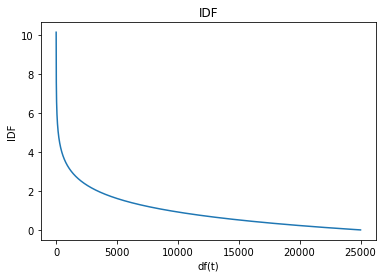

In [11]:
import numpy as np
import matplotlib.pyplot as plt
n_samples = 25000
idf = np.log(n_samples/np.arange(1,n_samples))
plt.title("IDF")
plt.xlabel("df(t)")
plt.ylabel("IDF")
plt.plot(idf)
plt.show()

## ストップワード
あまりにも頻繁に登場するトークンは、値を小さくするだけでなく、取り除くという前処理を加えることもあります。取り除くもののことを ストップワード と呼びます。既存のストップワード一覧を利用したり、しきい値によって求めたりします。


scikit-learnのCountVectorizerでは引数stop_wordsにリストで指定することで処理を行なってくれます。

In [12]:
vectorizer = CountVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a,bad,film,good,movie,this,very
0,0,0,0,1,1,1,1
1,1,0,1,1,0,1,0
2,0,2,0,0,0,0,3


代表的な既存のストップワード一覧としては、NLTK という自然言語処理のライブラリのものがあげられます。あるデータセットにおいては特別重要な意味を持つ単語が一覧に含まれている可能性もあるため、使用する際は中身を確認することが望ましいです。

In [13]:
# はじめて使う場合はストップワードをダウンロード
import nltk
stop_words = nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words)) # 'i', 'me', 'my', ...

stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

[nltk_data] Downloading package stopwords to /Users/arisa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


逆に、登場回数が特に少ないトークンも取り除くことが多いです。全てのトークンを用いるとベクトルの次元数が著しく大きくなってしまい計算コストが高まるためです。


scikit-learnのCountVectorizerでは引数max_featuresに最大の語彙数を指定することで処理を行なってくれます。以下の例では出現数が多い順に5個でベクトル化しています。

In [14]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features = 5)
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,bad,good,is,this,very
0,0,1,1,1,1
1,0,1,1,1,0
2,2,0,0,0,3


## 【問題2】TF-IDFの計算
IMDB映画レビューデータセットをTF-IDFによりベクトル化してください。NLTKのストップワードを利用し、最大の語彙数は5000程度に設定してください。テキストクリーニングやステミングなどの前処理はこの問題では要求しません。


TF-IDFの計算にはscikit-learnの以下のどちらかのクラスを使用してください。

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

なお、scikit-learnでは標準的な式とは異なる式が採用されています。


また、デフォルトではnorm="l2"の引数が設定されており、各サンプルにL2正規化が行われます。norm=Noneとすることで正規化は行われなくなります。


Term Frequency:
$$
tf(t,d) = n_{t,d}
$$

$n_{t,d}$: サンプルd内のトークンtの出現回数
scikit-learnのTFは分母がなくなりBoWと同じ計算になります。


Inverse Document Frequency:
$$
idf(t) = \log{\frac{1+N}{1+df(t)}}+1
$$

N : サンプル数


$df(t)$: トークンtが出現するサンプル数


＊logの底はネイピア数e


詳細は以下のドキュメントを確認してください。

https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting

### 問題2の実装

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(x_train).toarray()

In [43]:
#print(vectorizer.get_feature_names())

In [44]:
print(X_vec.shape)

(25000, 74849)


In [49]:
y_train.shape

(25000,)

## 【問題3】TF-IDFを用いた学習
問題2で求めたベクトルを用いてIMDB映画レビューデータセットの学習・推定を行なってください。モデルは2値分類が行える任意のものを利用してください。


ここでは精度の高さは求めませんが、最大の語彙数やストップワード、n-gramの数を変化させて影響を検証してみてください。

In [45]:
from sklearn.model_selection import train_test_split

In [50]:
X_train, X_val, y_train, y_val = train_test_split(X_vec, y_train, test_size=0.2)

In [51]:
# ロジスティック回帰
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)
yp_base = clf.predict(X_val)

In [52]:
from sklearn.metrics import accuracy_score
print("正解率：",accuracy_score(yp_base, y_val))

正解率： 0.8838


### ストップワード使用、最大語彙数50

In [57]:
# 最大語彙数を50にして軽いデータを作成
vectorizer_50= TfidfVectorizer(stop_words=stop_words, max_features=50, norm=None)
x_vec_50 = vectorizer_50.fit_transform(x_train).toarray()

In [58]:
X_train, X_val, Y_train, Y_val = train_test_split(x_vec_50, y_train, test_size=0.2)

In [59]:
clf_50 = LogisticRegression()
clf_50.fit(X_train, Y_train)
yp_50 = clf_50.predict(X_val)

In [60]:
print("正解率：",accuracy_score(yp_50, Y_val))

正解率： 0.7096


### ストップワードなし、最大語彙数50

In [61]:
# 最大語彙数を50にして軽いデータを作成
vectorizer_non50= TfidfVectorizer(max_features=50, norm=None)
x_vec_non50 = vectorizer_non50.fit_transform(x_train).toarray()

In [62]:
X_train, X_val, Y_train, Y_val = train_test_split(x_vec_non50, y_train, test_size=0.2)

In [63]:
clf_non50 = LogisticRegression()
clf_non50.fit(X_train, Y_train)
yp_non50 = clf_non50.predict(X_val)

In [64]:
print("正解率：",accuracy_score(yp_non50, Y_val))

正解率： 0.6534


### ストップワードあり、2-gram

In [65]:
# 最大語彙数を50にして軽いデータを作成
vectorizer_2gram= TfidfVectorizer(stop_words=stop_words, ngram_range=(2, 2), max_features=50, norm=None)
x_vec_2gram = vectorizer_2gram.fit_transform(x_train).toarray()

In [66]:
X_train, X_val, Y_train, Y_val = train_test_split(x_vec_2gram, y_train, test_size=0.2)

In [67]:
clf_2gram = LogisticRegression()
clf_2gram.fit(X_train, Y_train)
yp_2gram = clf_2gram.predict(X_val)

In [68]:
print("正解率：",accuracy_score(yp_2gram, Y_val))

正解率： 0.6166


考察：ストップワード有りの方が精度が高かった。gram1の方が精度が高かった。最大語彙数を減らすと正解率も大きく下がったが、処理の時間も短くなった

## 【問題4】TF-IDFのスクラッチ実装
以下の3文のTF-IDFを求められるプログラムをscikit-learnを使わずに作成してください。<br>
標準的な式と、scikit-learnの採用している式の2種類を作成してください。正規化は不要です。<br>

- This movie is SOOOO funny!!!
- What a movie! I never
- best movie ever!!!!! this movie

### sklearn

In [69]:
text = [
'This movie is SOOOO funny!!!',
'What a movie! I never',
'best movie ever!!!!! this movie'
]

In [71]:
vectorizer = TfidfVectorizer(norm=None)
text_vec = vectorizer.fit_transform(text).toarray()

In [72]:
print(vectorizer.get_feature_names())

['best', 'ever', 'funny', 'is', 'movie', 'never', 'soooo', 'this', 'what']


In [74]:
tf_idf_train = (vectorizer.fit_transform(text).toarray())
df = pd.DataFrame(tf_idf_train, columns=vectorizer.get_feature_names())
display(df)

,best,ever,funny,is,movie,never,soooo,this,what
0,0.000000,0.000000,1.693147,1.693147,1.0,0.000000,1.693147,1.287682,0.000000
1,0.000000,0.000000,0.000000,0.000000,1.0,1.693147,0.000000,0.000000,1.693147
2,1.693147,1.693147,0.000000,0.000000,2.0,0.000000,0.000000,1.287682,0.000000


### スクラッチ：標準的な式

In [90]:
def ScratchTFIDF(text):
    word_list = []
    for i in range(len(text)):
        token = re.split('[, /]',text[i])
        for j in range(len(token)):
            word_list.append(token[j])
                
    word_label = list(set(word_list))
    mat = np.zeros([len(text), len(word_label)])
    
    for i in range(len(text)):
        for j in range(len(word_label)):
            tf = text[i].count(word_label[j]) / len(re.split('[, /]',text[i]))
            count = 0
            for k in range(len(text)):
                if 0 < text[k].count(word_label[j]):
                    count += 1
            idf = np.log(len(text)/count)
            mat[i][j] = tf*idf
    #print(word_label)
    #print(mat)
    df = pd.DataFrame(mat, columns=word_label)
    display(df)

In [91]:
ScratchTFIDF(text)

,a,I,movie!,movie,SOOOO,best,ever!!!!!,never,funny!!!,What,this,is,This
0,0.000000,0.000000,0.000000,0.0,0.219722,0.000000,0.000000,0.000000,0.219722,0.000000,0.000000,0.162186,0.219722
1,0.439445,0.219722,0.219722,0.0,0.000000,0.000000,0.000000,0.219722,0.000000,0.219722,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.0,0.000000,0.219722,0.219722,0.000000,0.000000,0.000000,0.219722,0.081093,0.000000


### スクラッチ：scikit-learnの採用している式

In [92]:
def ScratchTFIDF_SK(text):
    word_list = []
    for i in range(len(text)):
        token = re.split('[, /]',text[i])
        for j in range(len(token)):
            word_list.append(token[j])
                
    word_label = list(set(word_list))
    mat = np.zeros([len(text), len(word_label)])
    
    for i in range(len(text)):
        for j in range(len(word_label)):
            tf = text[i].count(word_label[j])
            count = 0
            for k in range(len(text)):
                if 0 < text[k].count(word_label[j]):
                    count += 1
            idf = np.log((len(text) + 1)/(count + 1)) + 1
            mat[i][j] = tf*idf
    #print(word_label)
    #print(mat)
    df = pd.DataFrame(mat, columns=word_label)
    display(df)

In [93]:
ScratchTFIDF_SK(text)

,a,I,movie!,movie,SOOOO,best,ever!!!!!,never,funny!!!,What,this,is,This
0,0.000000,0.000000,0.000000,1.0,1.693147,0.000000,0.000000,0.000000,1.693147,0.000000,0.000000,2.575364,1.693147
1,3.386294,1.693147,1.693147,1.0,0.000000,0.000000,0.000000,1.693147,0.000000,1.693147,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,2.0,0.000000,1.693147,1.693147,0.000000,0.000000,0.000000,1.693147,1.287682,0.000000


In [95]:
vectorizer_sc= TfidfVectorizer(norm=None)
x_vec_sc = vectorizer_sc.fit_transform(text).toarray()

In [96]:
df = pd.DataFrame(x_vec_sc, columns=vectorizer_sc.get_feature_names())
display(df)

,best,ever,funny,is,movie,never,soooo,this,what
0,0.000000,0.000000,1.693147,1.693147,1.0,0.000000,1.693147,1.287682,0.000000
1,0.000000,0.000000,0.000000,0.000000,1.0,1.693147,0.000000,0.000000,1.693147
2,1.693147,1.693147,0.000000,0.000000,2.0,0.000000,0.000000,1.287682,0.000000


## Word2Vec
ニューラルネットワークを用いてベクトル化を行う手法が Word2Vec です。


BoWやTF-IDFはone-hot表現であったため、得られるベクトルの次元は語彙数分になります。そのため、語彙数を増やしにくいという問題があります。一方で、Word2Vecでは単語を任意の次元のベクトルに変換します。これをを Word Embedding（単語埋め込み） や 分散表現 と呼びます。変換操作を「ベクトル空間に埋め込む」と言うことが多いです。


Word2VecにはCBoWとSkip-gramという2種類の仕組みがあるため順番に見ていきます。


### CBoW
CBoW (Continuous Bag-of-Words) によるWord2Vecではある単語とある単語の間に来る単語を推定できるように全結合層2層のニューラルネットワークを学習します。


単語はコーパスの語彙数次元のone-hot表現を行なっておきます。そのため、入力と出力の次元は語彙数と同じになります。一方で、中間のノード数をWord2Vecにより得たい任意の次元数とします。これにより全結合層の重みは「得たい次元のノード数×語彙数」になります。このネットワークにより学習を行なった後、出力側の重みを取り出すことで、各語彙を表すベクトルを手に入れることができます。


間の単語の推定を行なっているため、同じ箇所で代替可能な言葉は似たベクトルになるというメリットもあります。これはBoWやTF-IDFでは得られない情報です。


あるテキストは「そのテキストの長さ（単語数）×Word2Vecで得た分散表現の次元数」の配列になりますが、各入力の配列を揃える必要があるモデルに入力するためには、短いテキストは空白を表す単語を加える パディング を行なったり、長いテキストは単語を消したりします。テキストを 固定長 にすると呼びます。

### ウィンドウサイズ
入力する単語は推定する前後1つずつだけでなく、複数個とする場合もあります。前後いくつを見るかの大きさを ウィンドウサイズ と呼びます。

### Skip-gram
CBoWとは逆にある単語の前後の単語を推定できるように全結合層2層のニューラルネットワークを学習する方法が Skip-gram です。学習を行なった後は入力側の重みを取り出し各語彙を表すベクトルとします。現在一般的に使われているのはCBoWよりもSki-gramです。

### 利用方法
Pythonでは Gensim ライブラリを用いて扱うことができます。
https://radimrehurek.com/gensim/models/word2vec.html

BoWの例と同じ文章で学習してみます。CountVectorizerと異なり前処理を自動的に行なってはくれないため、単語（トークン）はリストで分割しておきます。また、大文字は小文字に揃え、記号は取り除きます。


デフォルトのパラメータではCBoWで計算されます。また、ウィンドウサイズはwindow=5に設定されています。

In [98]:
from gensim.models import Word2Vec
sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習
print("語彙の一覧 : {}".format(model.wv.vocab.keys()))
for vocab in model.wv.vocab.keys():
  print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

語彙の一覧 : dict_keys(['this', 'movie', 'is', 'very', 'good', 'film', 'a', 'bad'])
thisのベクトル : 
[-0.02662116  0.0176387  -0.04640723 -0.03603607 -0.03983193  0.04744475
  0.02080979  0.03100929 -0.03336754  0.02293834]
movieのベクトル : 
[ 0.00374345 -0.04126974  0.00712079 -0.01543243  0.04141569 -0.03266859
 -0.03722949  0.04804384  0.00840449 -0.0373885 ]
isのベクトル : 
[ 4.1133519e-03  3.0619601e-02  4.6578422e-02  3.5008822e-02
 -2.1143414e-02  4.5892783e-02  1.0605002e-05  5.0248657e-03
  3.3616841e-02 -2.3979645e-02]
veryのベクトル : 
[-0.02023077 -0.03912916  0.01064228 -0.04079828 -0.0392892  -0.04185558
  0.03741433 -0.03298487 -0.00768175 -0.00613079]
goodのベクトル : 
[-0.03700087 -0.03591486  0.01200262 -0.04835247  0.04490133 -0.00122542
  0.02655091 -0.02727574 -0.0154673  -0.00153656]
filmのベクトル : 
[ 0.0370249  -0.00968983 -0.02703274  0.01699764  0.00015523  0.04652674
  0.00407525 -0.0199183  -0.04388898  0.01611501]
aのベクトル : 
[-0.00787545  0.00202103  0.02759698  0.03952957 -0.03291098 -0.0

/Users/arisa/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


### 単語の距離
ベクトル間で計算を行うことで、ある単語に似たベクトルを持つ単語を見つけることができます。例えばgoodに似たベクトルの単語を3つ探します。

In [99]:
model.wv.most_similar(positive="good", topn=3)

[('very', 0.49509215354919434),
 ('bad', 0.3468261659145355),
 ('movie', 0.1815365105867386)]

今の例では3文しか学習していませんので効果を発揮しませんが、大きなコーパスで学習することで、並列関係のものが近くに来たりなど面白い結果が得られます。

### 可視化
2次元に圧縮することで単語ごとの位置関係を可視化することができます。以下はt-SNEを用いた例です。

/Users/arisa/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


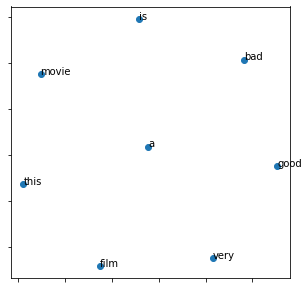

In [100]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

## IMDB映画レビューデータセットの分散表現
IMDB映画レビューデータセットの訓練データをコーパスとしてWord2Vecを学習させ分散表現を獲得しましょう。



## 【問題5】コーパスの前処理
コーパスの前処理として、特殊文字（!など）やURLの除去、大文字の小文字化といったことを行なってください。また、単語（トークン）はリストで分割してください。

### サンプルデータで確認

In [124]:
text = [
'This movie is SOOOO funny!!!',
'What a movie! I never',
'best movie ever!!!!! this movie'
]

In [133]:
text_list = []
for i in range(len(text)):
    text[i] = text[i].lower()
    #text[i] = re.sub(r"[^a-zA-Z0-9]+", " ", text[i])
    text[i] = text[i].replace(r"[^a-zA-Z0-9]+", "")
    text[i] = text[i].rstrip()
    token = re.split('[, /]',text[i])
    text_list.append(token)

In [134]:
text_list

[['this', 'movie', 'is', 'soooo', 'funny'],
 ['what', 'a', 'movie', 'i', 'never'],
 ['best', 'movie', 'ever', 'this', 'movie']]

In [135]:
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定
model.build_vocab(text_list) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習
print("語彙の一覧 : {}".format(model.wv.vocab.keys()))
for vocab in model.wv.vocab.keys():
    print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

語彙の一覧 : dict_keys(['this', 'movie', 'is', 'soooo', 'funny', 'what', 'a', 'i', 'never', 'best', 'ever'])
thisのベクトル : 
[-0.02662116  0.0176387  -0.04640723 -0.03603607 -0.03983193  0.04744475
  0.02080979  0.03100929 -0.03336754  0.02293834]
movieのベクトル : 
[ 0.00374345 -0.04126974  0.00712079 -0.01543243  0.04141569 -0.03266859
 -0.03722949  0.04804384  0.00840449 -0.0373885 ]
isのベクトル : 
[ 4.1133263e-03  3.0619409e-02  4.6578132e-02  3.5008602e-02
 -2.1143282e-02  4.5892496e-02  1.0604936e-05  5.0248341e-03
  3.3616632e-02 -2.3979494e-02]
sooooのベクトル : 
[ 0.03220742  0.00519683  0.03903654  0.0149874   0.03208504  0.02011322
  0.02522402 -0.02201126  0.04153448 -0.02762788]
funnyのベクトル : 
[ 0.04080604  0.0122753   0.01304101  0.00276528  0.01816266 -0.0439434
  0.01466237 -0.04031313 -0.02920861 -0.04165947]
whatのベクトル : 
[-0.02561819 -0.02223832 -0.00350261  0.03779     0.03028934  0.02773167
  0.00778862 -0.04865639  0.01095658 -0.00097947]
aのベクトル : 
[-0.00787545  0.00202103  0.02759698  0

/Users/arisa/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/arisa/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


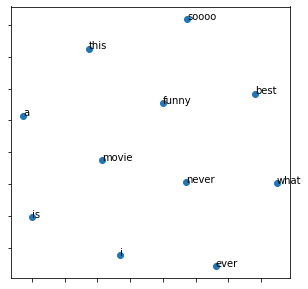

In [136]:
vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

In [138]:
text_list = []
X_test = x_test.copy()
for i in range(len(x_test)):
    X_test[i] = X_test[i].lower()
    #text[i] = re.sub(r"[^a-zA-Z0-9]+", " ", text[i])
    X_test[i] = X_test[i].replace(r"[^a-zA-Z0-9]+", "")
    X_test[i] = X_test[i].rstrip()
    token = re.split('[, /]',X_test[i])
    text_list.append(token)

## 【問題6】Word2Vecの学習

In [139]:
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定
model.build_vocab(text_list) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習

/Users/arisa/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(56, 75)

In [146]:
model.save("word2vec.model")

In [144]:
model.wv.most_similar(positive="good", topn=10)

[('role;', 0.9398078322410583),
 ('seppuku!', 0.9374410510063171),
 ('post-war.<br', 0.9360769391059875),
 ('cancerman)', 0.9313536882400513),
 ('cos', 0.9304590821266174),
 ("lucille's", 0.9262431859970093),
 ('hands...<br', 0.9242637753486633),
 ('01.', 0.9240878224372864),
 ('schooler', 0.9189344048500061),
 ('pasted', 0.91874760389328)]

In [145]:
model.wv.most_similar(positive="bad", topn=10)

[('down-vote', 0.9682837724685669),
 ('15%(the', 0.9645987749099731),
 ('tamakichi', 0.9593921303749084),
 ('odnt', 0.9520321488380432),
 ('arau)', 0.9451302289962769),
 ('ross(ala', 0.9448950290679932),
 ('dio...', 0.9437155723571777),
 ('honourable', 0.9341142773628235),
 ('!)..', 0.9306801557540894),
 ('shirt"', 0.9290185570716858)]